In [1]:
# Import libs
from sklearn.preprocessing import MinMaxScaler, StandardScaler, KBinsDiscretizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from numpy import ndarray
import time
import pandas as pd
from numpy import mean
from numpy import std
from math import sqrt
import numpy as np
import math
import json 
import random
import matplotlib.pyplot as plt

# Load pickle
from parseit.data import load_pickle, save_pickle

filename = "data-16k-dec-3-other"
#filename = "data-16k-dec-3-tfidf"
model_name = "svm-other"
#model_name = "svm-tfidf"

# Chose bins and qr
bins = 2
qr = 4

pickle_df = load_pickle(f"{filename}.p")
display(pickle_df)

,index,body,subreddit,submission,label,top-cos-sim,cos-sim,tfidf-mean,lnk,wc,sw,bw,nam,smil+,smil-,smil&
0,0,*What if Jod was one of us?*,askreddit,"What if God came down one day and said ""It's p...",429,0.000000,0.001759,0.200000,0,1,4,0,0,0,0,0
1,1,A large chunk of my taking the lord's name in ...,askreddit,"What if God came down one day and said ""It's p...",41259,0.000000,0.005759,0.153846,0,4,9,0,0,0,0,0
2,2,Do you want a Holy War? Because that's how you...,askreddit,"What if God came down one day and said ""It's p...",26069,0.000000,0.005984,0.136651,0,5,9,0,2,0,0,0
3,3,"He would also say, “my name isn’t God” then he...",askreddit,"What if God came down one day and said ""It's p...",6449,0.076923,0.007537,0.151364,0,5,11,0,1,0,0,0
4,4,"We’d be like, “No way!” and he’d be like, “Yah...",askreddit,"What if God came down one day and said ""It's p...",20046,0.111522,0.007880,0.224878,0,6,6,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16835,16835,Haha nice revenge.,todayilearned,"TIL the USS Arizona, sunk during the Pearl Har...",1,0.000000,0.005431,1.728557,0,3,0,0,0,0,0,0
16836,16836,Yawn,todayilearned,"TIL the USS Arizona, sunk during the Pearl Har...",-4,0.000000,0.003243,0.083333,0,1,0,0,0,0,0,0
16837,16837,BuT iTs a wAr GrAvE rEsPeCt tHe DeAd YoU cAnT ...,todayilearned,"TIL the USS Arizona, sunk during the Pearl Har...",0,0.034674,0.018033,0.686190,0,26,30,0,1,0,0,0
16838,16838,"""Right back at 'ya buckaroo""",todayilearned,"TIL the USS Arizona, sunk during the Pearl Har...",0,0.000000,0.005617,0.066617,0,2,2,0,0,0,0,0


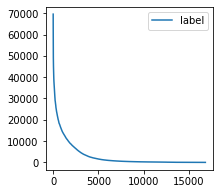

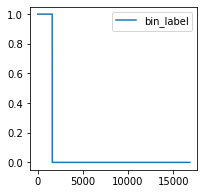

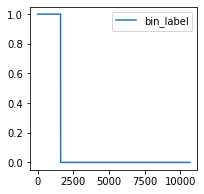

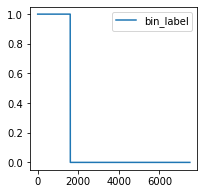

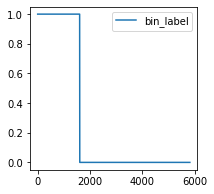

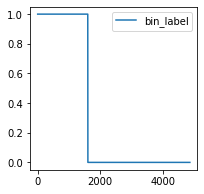

In [2]:
# Bin data here

# ideas:
# Drop indexs more from lower score and less from higher score [IMPLEMENTED!]
# https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset/28557333#28557333
# https://stats.stackexchange.com/questions/99667/naive-bayes-with-unbalanced-classes

# MemoryError: Unable to allocate 11.2 GiB for an array with shape (34416, 43556) and data type int64, so pick first 20000
df = pickle_df.copy()

# TODO: bows and tf-idf contains a word "label"
# Define y and X
y = df[["label"]]
X = df.drop(["body", "submission", "subreddit", "label"], axis=1)

# Show distribution of all data before we bin
label_sorted = y[["label"]].sort_values("label", ascending=False).reset_index().drop("index", axis=1)
label_sorted.plot.line(figsize=(3,3))
plt.savefig(f'graphs/{model_name}/{bins}-bins/label-dist-sorted')

# uniform = All bins in each feature have identical widths.
# quantile = All bins in each feature have the same number of points.
# kmeans = Values in each bin have the same nearest center of a 1D k-means cluster.
#   kmeans seems right: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_strategies.html
est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy="kmeans") # for a total_bins = 4, create binned data of 2 and 4
est.fit(y)
yt:ndarray = est.transform(y)
y_binned = pd.DataFrame(data=yt, columns=["bin_label"])
X_binned = X

bin_label_sorted = y_binned.sort_values("bin_label", ascending=False).reset_index().drop("index", axis=1)
bin_label_sorted.plot.line(figsize=(3,3))
plt.savefig(f'graphs/{model_name}/{bins}-bins/binning_{bins}-bins')

# We have so skewed data, so maybe we can drop off a few comments from the first large bins so that
# the distribution of comments in each bin are more even

# do this to shrink the size of each bin to have a max size of its quantile propotion; 
# if doing it repeatedly, the size of the entire sample shrinks so the quantile for each bin shrinks yet again
if True:
    for x in range(qr): 
        for b in range(bins):
            # check the proportion of a bin, i.e. the first bin might be 70%
            bin_proportion = len(y_binned[y_binned.bin_label == b]) / len(y_binned)
            # if there are five bins, no bin should be above 20% (which is one 5th or 1/5)
            # so if the bin is 70% of the entire sample, drop 50% so that the bin is only 20% max
            number_to_drop = math.floor((bin_proportion - 1/bins) * len(y_binned[y_binned.bin_label == b]))
            if number_to_drop > 0:
                indexes_to_drop = y_binned[y_binned.bin_label == b][-number_to_drop:]
                y_binned = y_binned.drop(index=indexes_to_drop.index)
                X_binned = X_binned.drop(index=indexes_to_drop.index)

        bin_label_sorted = y_binned.sort_values("bin_label", ascending=False).reset_index().drop("index", axis=1)
        bin_label_sorted.plot.line(figsize=(3,3))
        plt.savefig(f'graphs/{model_name}/{bins}-bins/binning_qr-{x+1}-of-{qr}')

# The first graph shows the distribution of of the labels, unbinned

# The second shows what happens when we bin the data with kmeans algorithm
# The third one shows what happens when we try to quantile the bins after a kmeans distribution (we see that we dropped of a lot of comments)


array([[654,   0],
       [134, 187]])

array([[654,   0],
       [124, 197]])

array([[650,   4],
       [137, 183]])

array([[652,   1],
       [135, 186]])

array([[653,   0],
       [115, 206]])

86.25641025641025% 841 correct guesses of 975 in split:1
87.28205128205128% 851 correct guesses of 975 in split:2
85.52361396303901% 833 correct guesses of 974 in split:3
86.0369609856263% 838 correct guesses of 974 in split:4
88.19301848049281% 859 correct guesses of 974 in split:5

Avarage accuracy for all splits (manually calculated): 86.65841099352394%

Accuracy: 86.65841099352394% (4221 comments of 4872)

Balanced accuracy: 79.81672881346826%


Graphs below shows predicted value vs true value. One graph per split.


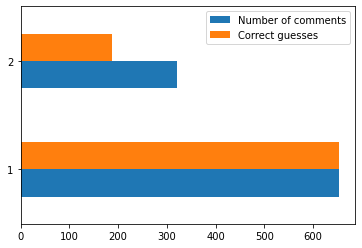

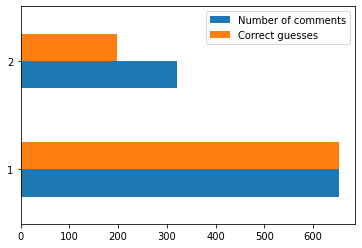

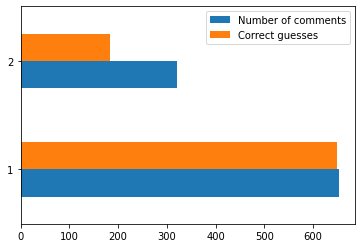

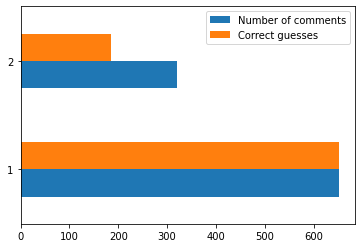

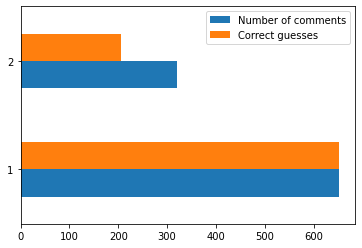

In [3]:
# ML here
txt_to_save = ""

# copy the binned y and X
yb = y_binned.copy()
Xb = X_binned.copy()

#display(yb)
splits = 5

true_values = []
pred_values = []
manual_accuracy = []
accuracies = np.array([])
balanced_accuracies = np.array([])
sentences = []
for i in range(bins):
    sentences.append({"correct":[], "incorrect":[]})

# https://stats.stackexchange.com/questions/131255/class-imbalance-in-supervised-machine-learning
# https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification/32820#32820
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
split = 1
skf = StratifiedKFold(n_splits=splits, random_state=42, shuffle=True)
for train_index, test_index in skf.split(Xb, yb):
    
    # fetch the train and validate k folds from Xb and yb
    X_train, X_validate = Xb.iloc[train_index], Xb.iloc[test_index]
    y_train, y_validate = yb.iloc[train_index], yb.iloc[test_index]
    #sub_df = df.iloc[test_index]

    # scale data
    scaler = MinMaxScaler() #
    scaler.fit(X_train, y_train) # Don't cheat: fit only training data. y is ignored, but still needs same shape
    
    # Model
    #model = svm.SVC(kernel="linear", random_state=42, tol=1e-4, max_iter=1000)
    model = LinearSVC(random_state=42, tol=1e-4, max_iter=1000)
    clf = model.fit(X_train, y_train)
    model.fit(scaler.transform(X_train), y_train) # Train the model using the training sets - scale only features (?)
    y_pred = model.predict(scaler.transform(X_validate)) # Predic the validation set


    ## DO NOT SCALE WITH TFIDF
    #model = LinearSVC(random_state=42, tol=1e-4, max_iter=1000)
    #model.fit(X_train, y_train) # Train the model using the training sets - scale only features (?)
    #y_pred = model.predict(X_validate) # Predic the validation set


    accuracy = metrics.accuracy_score(y_validate, y_pred, normalize=True) # check the accuracy
    balanced_accuracy = metrics.balanced_accuracy_score(y_validate, y_pred, adjusted=False) # check the balanced accuracy
    # TODO: balanced - stackoverflow.com/questions/55838262/why-does-cross-validation-give-consistently-higher-scores-than-normal-fitting-an
    # TODO: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html

    y_valid = y_validate["bin_label"].tolist()

    correct_guesses = 0
    for i in range(len(y_pred)):
        correct_guesses = correct_guesses+1 if y_pred[i] == y_valid[i] else correct_guesses

    txt_to_save = txt_to_save + f"{(correct_guesses/len(y_pred))*100}% {correct_guesses} correct guesses of {len(y_pred)} in split:{split}\n"
    results = pd.DataFrame({"pred": y_pred, "true": y_valid})

    # confusion matrix
    conf = confusion_matrix(y_valid, y_pred)
    display(conf)
    #plot_confusion_matrix(model, X_validate, y_validate, cmap="Blues")
    
    # Build graphs
    bin_indexes = [None]*bins
    preds = [None]*bins
    trues = [None]*bins
    corrects = [None]*bins
    correct_percentages = [None]*bins
    for i in range(bins):
        bin_index = results[results.true == i].index
        preds[i] = results["pred"][bin_index].tolist()
        trues[i] = results["true"][bin_index].tolist()
        bodis = df["body"][bin_index].tolist()
        subms = df["submission"][bin_index].tolist()
        subrs = df["subreddit"][bin_index].tolist()
        labls = df["label"][bin_index].tolist()
        corrects[i] = 0
        for j in range(len(trues[i])):
            if trues[i][j] == preds[i][j]:
                corrects[i] = corrects[i]+1 

                if len(sentences[i]["correct"]) < 21 and random.randint(0,100) < 20:
                    sentences[i]["correct"].append({
                        "sent": bodis[j], 
                        #"subm": subms[j],
                        #"subr": subrs[j],
                        "labl": labls[j],
                        "true_bin": int(trues[i][j]+1),
                        "pred_bin": int(preds[i][j]+1),
                    })
            else:
                if len(sentences[i]["incorrect"]) < 21 and random.randint(0,100) < 20:
                    sentences[i]["incorrect"].append({
                        "sent": bodis[j], 
                        #"subm": subms[j],
                        #"subr": subrs[j],
                        "labl": labls[j],
                        "true_bin": int(trues[i][j]+1),
                        "pred_bin": int(preds[i][j]+1),
                    })
        correct_percentages[i] = 100*corrects[i]/len(trues[i])


    plot_df = pd.DataFrame({
        "Number of comments": [len(t) for t in trues],
        "Correct guesses": [c for c in corrects],
    }, index=[str(i+1) for i in range(bins)])
    plot_df.plot.barh()
    plt.savefig(f'graphs/{model_name}/{bins}-bins/predicting_split-{split}-of-{splits}')

    manual_accuracy.append(correct_guesses/len(y_pred))
    true_values.append(y_valid)
    pred_values.append(y_pred)
    accuracies = np.append(accuracies, accuracy)
    balanced_accuracies = np.append(balanced_accuracies, balanced_accuracy)

    # counter
    split = split+1

    #results.plot.scatter(x="pred", y="true")
    #results.plot.barh(x=, y)


txt_to_save = txt_to_save + f"\nAvarage accuracy for all splits (manually calculated): {(sum(manual_accuracy)/splits)*100}%\n\n"

#print(f'Accuracy: {"%.2f" % (accuracy_norm * 100)}% ({accuracy} comments of {math.floor(len(y.index)*test_size)}) for k={kk}')
txt_to_save = txt_to_save + f"Accuracy: {(np.mean(accuracies) * 100)}% ({math.floor(np.mean(accuracies)*len(yb))} comments of {len(yb)})\n\n"
txt_to_save = txt_to_save + f"Balanced accuracy: {(np.mean(balanced_accuracies) * 100)}%\n\n"

with open(f"graphs/{model_name}/{bins}-bins/data.txt", "w") as fh:
    fh.write(txt_to_save)

with open(f"graphs/{model_name}/{bins}-bins/sentences.json", "w") as fh:
    fh.write(json.dumps(sentences, indent=4, sort_keys=False))

print(txt_to_save)
print("Graphs below shows predicted value vs true value. One graph per split.")
